In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import norm
from tqdm import tqdm

import pywt
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import ScalarFormatter, FixedFormatter, NullFormatter
from math import log2, ceil

from Objects.SyntheticData import SyntheticData
from Objects.RollingAverage import RollAverage
from Objects.FLH import FLH
from Objects.IFLH import IFLH
from Objects.TFLH import TFLH
from Objects.ARROWS import ARROWS
from Objects.RollingAverage import RollAverage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
n = 10000
segment_size = 2000
np.random.seed(42)

#choose between 'hard_shift', 'hard_shift_2', or 'soft_shift'
theta_type = 'hard_shift'

data = SyntheticData(
    n = n, 
    parameter_scale = 1, 
    sample_mean = 0, 
    sample_var = 1,
    theta_type = theta_type,
    segment_size = segment_size
)
data.run()

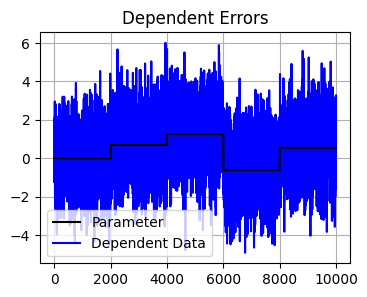

In [24]:
ind_data = False #if True, we see independent errors, if false we see dependent errors
fig, ax = plt.subplots(figsize = (4,3))

if ind_data:
    ax.plot(data.theta, color = 'k', label = 'Parameter', zorder = 10)
    ax.plot(data.ind, color = 'red', label = 'Independent Data', zorder = 5)
    ax.set_title('Independent Errors')

else:
    ax.plot(data.theta, color = 'k', label = 'Parameter', zorder = 10)
    ax.plot(data.dep, color = 'blue', label = 'Dependent Data', zorder = 5)
    ax.set_title('Dependent Errors')

ax.grid()
ax.legend()
plt.show()

In [25]:
#hyperparamters

SIGMA = np.sqrt(1)   #standard deviation of the noise
BETA = 24+1e-10    #ARROWS parameter (must be > 24)
ALPHA = 0.5/(np.log(n) ** 1)
ALPHA_T = 1/(np.log(n) ** 0.8) #learning rate for FLH
lookback = 100 #lookback

gamma = 1.1 #\gamma > 1
M = int(np.log(n) ** gamma) # number of bins for data thinning

y_data_dep = data.dep
y_data_ind = data.ind
theta = data.theta

In [26]:
#run IFLH

flh_algorithm = IFLH(alpha=ALPHA)
pred_dep, loss_dep = flh_algorithm.run(y_data_dep, theta)
pred_ind, loss_ind = flh_algorithm.run(y_data_ind, theta)
loss_dep = np.nancumsum(loss_dep)
loss_ind = np.nancumsum(loss_ind)

100%|██████████| 10000/10000 [00:10<00:00, 956.71it/s]


In [27]:
#run TFLH

thinned_flh_runner = TFLH(m=M, alpha=ALPHA_T)
predt_dep, predt_avg_dep, losst_dep, losst_avg_dep = thinned_flh_runner.run(y_data_dep, theta)
predt_ind, predt_avg_ind, losst_ind, losst_avg_ind = thinned_flh_runner.run(y_data_ind, theta)

100%|██████████| 909/909 [00:00<00:00, 1292.74it/s]


In [14]:
#run ARROWS

arrows_detector = ARROWS(n=n, sigma=SIGMA, beta=BETA)
preda_dep, lossa_dep = arrows_detector.run(y_data_dep, theta)
preda_ind, lossa_ind = arrows_detector.run(y_data_ind, theta)

100%|██████████| 10000/10000 [00:02<00:00, 4235.71it/s]


In [15]:
#run rolling average

rolling_average = RollAverage(lookback = lookback)
pred_dep_roll, loss_dep_roll = rolling_average.run(y_data_dep, theta)
pred_ind_roll, loss_ind_roll = rolling_average.run(y_data_ind, theta)
loss_dep_roll, loss_ind_roll = np.nancumsum(loss_dep_roll), np.nancumsum(loss_ind_roll)

100%|██████████| 10000/10000 [00:00<00:00, 140765.46it/s]


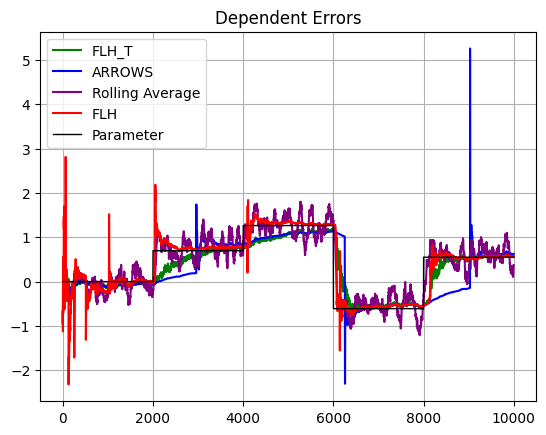

In [29]:
flh_c, flht_c, arrows_c, roll_c = True, True, True, True #which algorithm to include
theta_c, error_c = True, False #whether to include paramter and/or errors respectively
ind, dep = False, True #whether to include independent or dependent cases

x = 0
y = n

fig, ax = plt.subplots()

if error_c:
    if ind:
        ax.plot(y_data_ind[x:y], color = 'c', label = 'Ground Truth')
    if dep:
        ax.plot(y_data_dep[x:y], color = 'c', label = 'Ground Truth')

if flht_c:
    if ind:
        ax.plot(predt_avg_ind[x:y], color = 'g', label = 'FLH_T')
    if dep:
        ax.plot(predt_avg_dep[x:y], color = 'g', label = 'FLH_T')
        
if arrows_c:
    if ind:
        ax.plot(preda_ind[x:y], color = 'b', label = 'ARROWS')
    if dep:
        ax.plot(preda_dep[x:y], color = 'b', label = 'ARROWS')

if roll_c:
    if ind:
        ax.plot(pred_ind_roll[x:y], color = 'purple', label = 'Rolling Average')
    if dep:
        ax.plot(pred_dep_roll[x:y], color = 'purple', label = 'Rolling Average')

if flh_c:
    if ind:
        ax.plot(pred_ind[x:y], color = 'r', label = 'FLH')
    if dep:
        ax.plot(pred_dep[x:y], color = 'r', label = 'FLH')

if theta_c:
    if ind:
        ax.plot(theta[x:y], color = 'k', label = 'Parameter', linewidth = 1)
    if dep:
        ax.plot(theta[x:y], color = 'k', label = 'Parameter', linewidth = 1)

if ind:
    ax.set_title("Independent Errors")
if dep:
    ax.set_title("Dependent Errors")

ax.legend()
ax.grid()

plt.show()

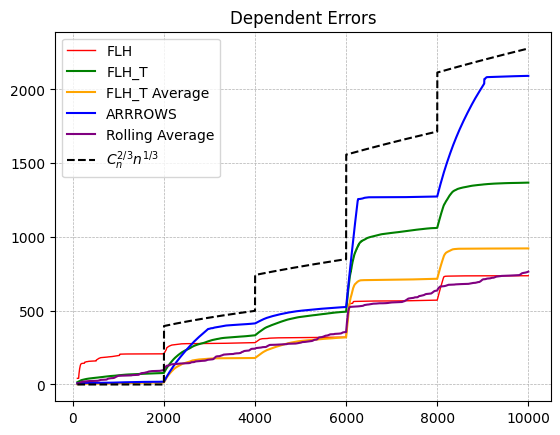

In [30]:
check_flh, check_tflh, check_tflh_avg, check_arrows = True, True, True, True
check_ind, check_dep = False, True
check_optimal = True
check_roll = True

start_index = 100
x_values = np.arange(start_index, n)

fig, ax = plt.subplots()

if check_flh:
    if check_dep:
        ax.plot(x_values, loss_dep[start_index:], color = 'r', label = 'FLH', linewidth = 1)
    if check_ind:
        ax.plot(x_values, loss_ind[start_index:], color = 'r', label = 'FLH', linewidth = 1)
if check_tflh:
    if check_dep:
        ax.plot(x_values, losst_dep[start_index:], color = 'g', label = 'FLH_T')
    if check_ind:
        ax.plot(x_values, losst_ind[start_index:], color = 'g', label = 'FLH_T')
if check_tflh_avg:
    if check_dep:
        ax.plot(x_values, losst_avg_dep[start_index:], color = 'orange', label = 'FLH_T Average')
    if check_ind:
        ax.plot(x_values, losst_avg_ind[start_index:], color = 'orange', label = 'FLH_T Average')
if check_arrows:
    if check_dep:
        ax.plot(x_values, lossa_dep[start_index:], color = 'b', label = 'ARRROWS')
    if check_ind:
        ax.plot(x_values, lossa_ind[start_index:], color = 'b', label = 'ARRROWS')
if check_roll:
    if check_dep:
        ax.plot(x_values, loss_dep_roll[start_index:], color = 'purple', label = "Rolling Average")
    if check_ind:
        ax.plot(x_values, loss_ind_roll[start_index:], color = 'purple', label = "Rolling Average")
if check_optimal: #dashed optimal line, play around with constant to get good plot
    ax.plot(x_values, (40*data.bound)[start_index:], color = 'k', label = r'$C_n^{2/3}n^{1/3}$', linestyle = 'dashed')


ax.grid(True, which="major", linestyle='--', linewidth=0.5)
ax.legend()
if check_ind:
    ax.set_title("Independent Errors")
if check_dep:
    ax.set_title("Dependent Errors")
plt.show()